In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline
from IPython.display import display
pd.options.display.max_columns = None

# Regression - Classification

## Exercise 1: Titanic, but correctly this time!

Take your linear regression model from the previous workshop on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [2]:
# exercise 1

In [3]:
# prep the data
titanic = sns.load_dataset('titanic')

# rename annoying class column
titanic.rename(columns={'class': 'Class'}, inplace=True)

# change types
titanic.Class = titanic.Class.astype(object)
titanic.deck = titanic.deck.astype(object)
titanic.alone = titanic.alone.astype(int)
titanic.adult_male = titanic.adult_male.astype(int)

# fill nan values in age 
age_list = titanic.age.dropna()
for row in range(len(titanic.age)): # fill age nan with random age choices
    if titanic.age.isna()[row]:
        titanic.loc[row, 'age'] = np.random.choice(age_list)

# fill nan for embarked 
titanic.embarked.fillna(method='bfill', inplace=True)

# fill nan in deck
titanic.deck = titanic.deck.fillna('Unk')

# make bins for deck
titanic['deck_bin'] = titanic.deck.map(lambda x: 'ABC' if x in ['A','B','C'] else('DE' if x in ['D','E'] else ('FG' if x in ['F','G'] else 'Unk')))

# make bins for fare to test and see if they are meaningful
titanic['fare_bin'] = titanic.fare.map(lambda x: 1 if x <= 25 else(3 if x >= 125 else 2))

# make family size column
titanic['family_size'] = titanic.sibsp + titanic.parch + 1

X = titanic.drop(['survived'], axis=1)
y = titanic.survived

In [4]:
# testing the same formula that I used for the regularized regression in previous exercise

formula = 'survived ~ Class + who + C(fare_bin) + embarked + deck_bin + family_size + adult_male'

# split for testing then make combined train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [5]:
# linear regression summary

ols_mod = smf.ols(formula=formula, data=train_data).fit()
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     40.63
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           6.42e-70
Time:                        12:34:44   Log-Likelihood:                -254.67
No. Observations:                 623   AIC:                             535.3
Df Residuals:                     610   BIC:                             593.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0701      0.089     11.967      0.000       0.894       1.246
Class[T.Second]     -0.0133      0.078     -0.171      0.864      -0.166       0.139
Class[T.Third]      -0.1432      0.084     -1.704      0.089      -0.308       0.022
who[T.man]          -0.2979      0.029    -10.112      0.000      -0.356      -0.240
who[T.woman]        -0.0095      0.060     -0.158      0.874      -0.127       0.108
C(fare_bin)[T.2]     0.0236      0.055      0.428      0.669      -0.085       0.132
C(fare_bin)[T.3]     0.0959      0.097      0.989      0.323      -0.094       0.286
embarked[T.Q]        0.0026      0.064      0.041      0.967      -0.123       0.129
embarked[T.S]       -0.0836      0.040     -2.114      0.035      -0.161      -0.006
deck_bin[T.DE]       0.1067      0.069      1.553      0.121      -0.028       0.242
deck_bin[T.FG]       0.0099      0.129      0.076      0.939      -0.244       0.264
deck_bin[T.Unk]     -0.1101      0.071     -1.552      0.121      -0.249       0.029
family_size         -0.0584      0.012     -4.767      0.000      -0.082      -0.034
adult_male          -0.2979      0.029    -10.112      0.000      -0.356      -0.240
==============================================================================
Omnibus:                       34.014   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.272
Skew:                           0.572   Prob(JB):                     4.89e-09
Kurtosis:                       3.406   Cond. No.                     9.08e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.46e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [6]:
# logistic regression summary

log_mod = smf.logit(formula=formula, data=train_data).fit()
log_mod.summary()

Optimization terminated successfully.
         Current function value: 0.409517
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  623
Model:                          Logit   Df Residuals:                      610
Method:                           MLE   Df Model:                           12
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:                  0.3889
Time:                        12:34:44   Log-Likelihood:                -255.13
converged:                       True   LL-Null:                       -417.52
Covariance Type:            nonrobust   LLR p-value:                 2.884e-62
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.9325      0.679      5.789      0.000       2.601       5.264
Class[T.Second]      0.0087      0.570      0.015      0.988      -1.109       1.126
Class[T.Third]      -0.9105      0.617     -1.476      0.140      -2.120       0.299
who[T.man]          -1.8481   2.19e+07  -8.43e-08      1.000    -4.3e+07     4.3e+07
who[T.woman]        -0.2991      0.423     -0.707      0.480      -1.129       0.530
C(fare_bin)[T.2]     0.2716      0.399      0.680      0.496      -0.511       1.054
C(fare_bin)[T.3]     0.8704      0.745      1.169      0.242      -0.589       2.330
embarked[T.Q]       -0.0120      0.471     -0.026      0.980      -0.935       0.911
embarked[T.S]       -0.6305      0.293     -2.149      0.032      -1.206      -0.055
deck_bin[T.DE]       0.8093      0.496      1.632      0.103      -0.163       1.781
deck_bin[T.FG]      -0.1121      0.951     -0.118      0.906      -1.977       1.752
deck_bin[T.Unk]     -0.7392      0.509     -1.451      0.147      -1.737       0.259
family_size         -0.4749      0.112     -4.250      0.000      -0.694      -0.256
adult_male          -1.8481   2.19e+07  -8.43e-08      1.000    -4.3e+07     4.3e+07
====================================================================================
"""

In [7]:
# linear regression accuracy value

pred_ols = ols_mod.predict(test_data)

cutoff = 0.5
y_pred_ols = np.where(pred_ols > cutoff, 1, 0)

accuracy = metrics.accuracy_score(y_test, y_pred_ols)
accuracy

0.8097014925373134

In [8]:
# logistic regression accuracy value

pred_log = log_mod.predict(test_data)

cutoff = 0.5
y_pred_log = np.where(pred_log > cutoff, 1, 0)

accuracy = metrics.accuracy_score(y_test, y_pred_log)
accuracy

0.8208955223880597

In [9]:
# linear regression classification report

print(metrics.classification_report(y_test, y_pred_ols))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       171
           1       0.73      0.74      0.74        97

    accuracy                           0.81       268
   macro avg       0.79      0.80      0.79       268
weighted avg       0.81      0.81      0.81       268



In [10]:
# logistic regression classification report

print(metrics.classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       171
           1       0.74      0.77      0.76        97

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



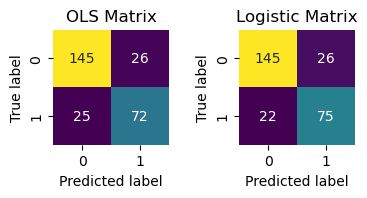

In [11]:
fig = plt.figure(figsize=(4,2))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.tight_layout(pad=2)

sns.heatmap(metrics.confusion_matrix(y_test, y_pred_ols), cmap='viridis', annot=True, fmt="d", ax=ax1, cbar=False)
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')
ax1.set_title('OLS Matrix')
sns.heatmap(metrics.confusion_matrix(y_test, y_pred_log), cmap='viridis', annot=True, fmt="d", ax=ax2, cbar=False)
ax2.set_xlabel('Predicted label')
ax2.set_ylabel('True label')
ax2.set_title('Logistic Matrix')

plt.show()

# confusion matrix for quick comparison

In [12]:
# the difference between models is not huge but logistic regression is better by a percentage point or two.
# linear regression did the worst for determining who survived whereas logistic regression performed better
# by correctly classifying 3 more survivors

In [13]:
# just out of curiosity, running the regularized model as well
# this is the worst performing of them all

model_r = smf.ols(formula=formula, data=train_data).fit_regularized(method='elastic_net', alpha=0.01)

In [14]:
pred_reg = model_r.predict(test_data)

cutoff = 0.5
y_pred_reg = np.where(pred_reg > cutoff, 1, 0)

accuracy = metrics.accuracy_score(y_test, y_pred_reg)
accuracy

0.7985074626865671

In [15]:
print(metrics.classification_report(y_test, y_pred_reg))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       171
           1       0.73      0.70      0.72        97

    accuracy                           0.80       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268



## Exercise 2: Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.
- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 

```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.
- You should be able to get at least 80% on a test set size of 10_000

In [16]:
# exercise 2

from sklearn.datasets import fetch_openml
data = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [17]:
X_ = data[0]
y_ = data[1]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_, y_, test_size=10000, random_state=13)

In [18]:
# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_poly = poly.fit_transform(X_train2[:20])

# polynomial features is too big, it's not a good option for my laptop even if it were done in batches

In [19]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# this is the most I was able to get to work, l2 penalty is default so regularization is included

In [20]:
model = pipeline.fit(X_train2, y_train2)

# this already took a long time to run, not sure how to do anything more complicated

In [21]:
# prediction time

y_pred2 = model.predict(X_test2)

In [22]:
print(metrics.classification_report(y_test2, y_pred2))

# all precision and recall values are greater than 80% so this is acceptable
# 5 and 8 had the lowest f1 scores by a couple percentage points
# so that would be an area to look for improvements to the model

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       999
           1       0.95      0.97      0.96      1142
           2       0.91      0.87      0.89       983
           3       0.89      0.89      0.89       983
           4       0.92      0.93      0.93       990
           5       0.88      0.87      0.87       929
           6       0.94      0.95      0.95      1014
           7       0.92      0.92      0.92      1044
           8       0.87      0.86      0.86       942
           9       0.90      0.89      0.89       974

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



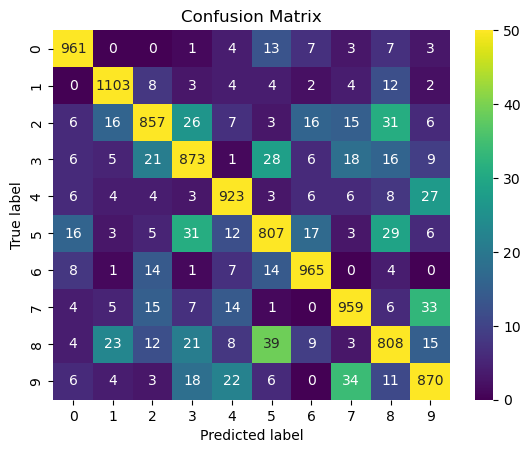

In [23]:
sns.heatmap(metrics.confusion_matrix(y_test2, y_pred2), cmap='viridis', vmax=50, annot=True, fmt="d")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

plt.show()

# this is an easier way to see where there were misclassifications
# the most common misclassification is 8 as 5, which makes sense
# 7 and 9 were the next most commonly misclassified